In [2]:
from util.sound_processing import *

In [3]:
import numpy as np
import json
from matplotlib import pyplot as plt
import os
from scipy.interpolate import interp1d

VOWELS = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW', "ER", "N"])

In [4]:
dir = "E:/MASC/Structured_data/rolling_in_the_deep_adele"
file_name_template = "audio"
lyric = combine_lyric_alignment_textgrids(dir, file_name_template)

In [5]:
lyric.compute_self_pitch_intervals()
lyric.compute_self_vibrato_intervals()
lyric.compute_self_singing_style_intervals()
lyric.write_textgrid(dir, file_name_template+"_new")


In [5]:
def generate_animation_ctrl_pts(start, end, value, sustain=1, decay = 0.75, onset=0.1, offset=0):
    interval = []
    interval.append([start-onset, 0])
    # second point is when the belting starts 
    interval.append([start, 1 * value])
    # third point emphasizes decay, it happens 75% down the interval
    if sustain < 1:
        interval.append([start + sustain * (end - start), decay * value])
        # last point is where the furrowing ends
        interval.append([end+offset, 0])
    elif sustain == 1:
        interval.append([end, value])
        # last point is where the furrowing ends
        interval.append([end+offset, 0])
    return interval

## 2. Compute coarse intervals from fine ones

In [9]:
intervals = lyric.voice_quality_intervals
traits = lyric.voice_quality_lists
def compute_coarse_intervals(traits, interval):
    new_intervals = []
    new_traits = []
    for i in range(0, len(intervals)):
        new_interval = []
        new_trait = []
        interval = intervals[i]
        trait = traits[i]
        if len(trait) > 1:
            prev_trait = trait[0]
            prev_index = 0
            for k in range(1, len(trait)):
                if trait[k] == prev_trait and k == len(trait)-1:
                    new_trait.append(prev_trait)
                    new_interval.append([interval[prev_index][0], interval[k][1]])
                elif trait[k] == prev_trait:
                    continue
                elif trait[k] != prev_trait:
                    new_trait.append(prev_trait)
                    new_interval.append([interval[prev_index][0], interval[k-1][1]])
                    prev_trait = trait[k]
            new_traits.append(new_trait)
            new_intervals.append(new_interval)
        else:
            new_traits.append(trait)
            new_intervals.append(interval)
    return new_traits, new_intervals
new_traits, new_interval = compute_coarse_intervals(traits, intervals)

[[], [], [], ['head'], [], [], ['head'], [], ['belt'], [], [], [], ['head'], [], [], ['head'], [], [], ['belt'], [], [], [], [], ['belt'], [], ['head'], [], [], ['belt'], ['head'], [], [], ['head'], [], [], ['head'], [], [], [], [], ['head'], [], [], ['head'], [], [], [], ['head'], [], [], ['head'], [], [], [], ['head'], ['head'], [], ['belt'], [], [], ['head'], [], [], [], ['belt'], [], [], [], ['belt'], ['head'], [], [], [], [], ['head'], ['head'], [], [], [], ['belt'], [], [], [], ['head'], [], [], ['head'], [], [], [], ['head'], [], [], ['head'], [], [], ['head'], []]
[[], [], [], ['head'], [], [], ['head'], [], ['belt'], [], [], [], ['head'], [], [], ['head'], [], [], ['belt', 'belt', 'belt', 'belt', 'belt', 'belt', 'belt', 'belt', 'belt'], [], [], [], [], ['belt'], [], ['head'], [], [], ['belt'], ['head'], [], [], ['head'], [], [], ['head', 'head', 'head', 'head', 'head', 'head', 'head', 'head', 'head', 'head'], [], [], [], [], ['head'], [], [], ['head'], [], [], [], ['head'], []

## 1. Compute Eye Brow Movements

In [65]:
# break the thing into sentence structures
sentences = []
current_sentence = []
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] == "EOS_tag":
        sentences.append(current_sentence)
        current_sentence = []
    else:
        current_sentence.append(i)
        if i == len(lyric.phoneme_list) - 1:
            sentences.append(current_sentence)
sentences = sentences[1:] 
# sentence stores the indexes

## 1.b Compute Eye Brow Movements version 2
This will change the data format for saving, and use more information

In [39]:
# break the thing into sentence structures
sentences = []
current_sentence = []
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] == "EOS_tag":
        sentences.append(current_sentence)
        current_sentence = []
    else:
        current_sentence.append(i)
        if i == len(lyric.phoneme_list) - 1:
            sentences.append(current_sentence)
sentences = sentences[1:] 
# sentence stores the indexes

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]]


In [69]:
# this is mostly for word level i.e. long vowels in a word. It would also be necessary to explore
# sentence level expressions (possibly from studying another song)
# this will have array of either 3 or 4 control points. 
# i.e. [[[ctrl_pt_1]...[ctrl_pt_k]], [[ctrl_pt_1]...[ctrl_pt_k]]] 
brow_movement = []
brow_ctrl_points = []
eye_movement = []
eye_ctrl_points = []
for i in range(0, len(sentences)):
    sentence = sentences[i]
    has_belt_pitch_interval_id = -1
    has_belt_word_id = -1
    has_head_pitch_interval_id = -1
    has_head_word_id = -1
    only_has_pitch_interval_id = -1
    only_has_head_word_id = -1
    
    for phone_id in sentence:
        phone = lyric.phoneme_list[phone_id]
        voice_qualities = lyric.coarse_voice_quality_lists[phone_id]
        voice_intervals = lyric.coarse_voice_quality_intervals[phone_id]
        # look to see if there are any parts that has belting
        for voice_quality_id in range(0, len(voice_qualities)):
            if (voice_qualities[voice_quality_id] == "belt" and has_belt_word_id < 0 and 
                voice_intervals[voice_quality_id][1] -  voice_intervals[voice_quality_id][0] >= 0.4):
                has_belt_word_id = phone_id
                has_belt_pitch_interval_id = voice_quality_id
            elif (voice_qualities[voice_quality_id] == "head" and has_belt_word_id >= 0 and has_head_word_id < 0 and 
                 voice_intervals[voice_quality_id][1] -  voice_intervals[voice_quality_id][0] >= 0.2):
                has_head_word_id = phone_id
                has_head_pitch_interval_id = voice_quality_id
            if has_belt_word_id > 0 and has_head_word_id > 0:
                break
                
    # do a second pass looking for brow raises
    if has_belt_word_id < 0 and has_head_word_id < 0:
        for phone_id in sentence:
            phone = lyric.phoneme_list[phone_id]
            pitch_change_interval = lyric.pitch_intervals[phone_id]
            pitch_change_slopes = lyric.pitch_slopes[phone_id]
            # look to see if there are any parts that has belting
            for vi in range(0, len(pitch_change_slopes)):
                if pitch_change_slopes[vi] >= 100 and only_has_head_word_id < 0:
                    only_has_head_word_id = phone_id 
                    only_has_pitch_interval_id = vi
                    break
            if only_has_head_word_id >= 0:
                break
                
    # this section of the code deal with having head voice only segments and the eye
    # brow raising in those 
    if only_has_head_word_id > 0:
        value = 5
        onset = lyric.pitch_intervals[only_has_head_word_id][0][0]
        start = lyric.pitch_intervals[only_has_head_word_id][only_has_pitch_interval_id][0] # where belting starts
        onset = start - onset
        end = lyric.pitch_intervals[only_has_head_word_id][-1][1]
        interval = generate_animation_ctrl_pts(start, end, value, 0.75, onset)
        brow_movement.append("raise")
        brow_ctrl_points.append(interval)
        
    # this section of the code deal with belting and the related physiological points of the eyes
    if has_belt_word_id > 0 and has_head_word_id > 0:
        # deal with the furrowing related movements
        value = 8
        start = lyric.voice_quality_intervals[has_belt_word_id][has_belt_pitch_interval_id][0] # where belting starts
        end = lyric.voice_quality_intervals[has_head_word_id][has_head_pitch_interval_id][0] # where head voice starts i.e. end 
                                                                                             # end of belting   
        interval = generate_animation_ctrl_pts(start, end, value, 0.75, 0.1)
        brow_movement.append("furrow")
        brow_ctrl_points.append(interval)
        
        # deal with the eyebrow raise related movements
         
        value = 5
        start = lyric.voice_quality_intervals[has_head_word_id][has_head_pitch_interval_id][0]
        end = lyric.voice_quality_intervals[has_head_word_id][has_head_pitch_interval_id][1]        
        interval = generate_animation_ctrl_pts(start, end, value, 0.75, 0.1)
        brow_ctrl_points.append(interval)
        brow_movement.append("raise")
        
        # deal with eye openning and closing
        value = 10
        start = lyric.voice_quality_intervals[has_belt_word_id][has_belt_pitch_interval_id][0] # where belting starts
        end = lyric.voice_quality_intervals[has_head_word_id][has_head_pitch_interval_id][0] # where head voice starts i.e. end 
        interval = generate_animation_ctrl_pts(start, end, value, 1, 0.1)
        eye_movement.append("closure")
        eye_ctrl_points.append(interval)
        
    elif has_belt_word_id > 0 and has_head_word_id < 0:
        # if there is belting, but sentence do not end with the use of head voice
        value = 8
        start = lyric.voice_quality_intervals[has_belt_word_id][has_belt_pitch_interval_id][0]
        start = min(start - 0.1, lyric.voice_quality_intervals[has_belt_word_id][0][0]) 
        end = lyric.phoneme_intervals[sentence[-1]][1]-0.1
        interval = generate_animation_ctrl_pts(start, end, value, 0.75, 0.05)
        brow_movement.append("furrow")
        brow_ctrl_points.append(interval)
        
        value = 10
        end = lyric.phoneme_intervals[sentence[-1]][1]-0.1 # end of this sentence if there is no next sentence
        if i < len(sentences)-1:
            # the end will be the first word from the next sentence if there are more than one sentence
            start_of_next_sentence = -1
            next_sentence = sentences[i+1]
            for phone_id in next_sentence:
                if lyric.phoneme_list[phone_id] in VOWELS:
                    start_of_next_sentence = phone_id
                    break
            end = lyric.phoneme_intervals[start_of_next_sentence][0]
        interval = generate_animation_ctrl_pts(start, end, value, 1, 1, 0.05, 0.1)
        eye_movement.append("closure")
        eye_ctrl_points.append(interval)
brow_movement.append("raise")
brow_movement.append("furrow")
brow_ctrl_points.append([[lyric.phoneme_intervals[-1][1], 0]])
brow_ctrl_points.append([[lyric.phoneme_intervals[-1][1], 0]])

### 1.c Compute additional Eye Brow Movements:

In [79]:
def get_brow_ctrl_pts(max_mean, mean_min, prev_freq, next_freq, mean_freq, time_range):
    max_fluctuation = 1
    rtv_raise = []
    rtv_furrow = []
    prev_freq_relative = prev_freq - mean_freq
    next_freq_relative = next_freq - mean_freq
    if prev_freq_relative < 0 and next_freq_relative < 0:
        rtv_furrow.append([time_range[0], abs(max_fluctuation * prev_freq_relative/mean_min)])
        rtv_furrow.append([time_range[1], abs(max_fluctuation * next_freq_relative/mean_min)])
    elif prev_freq_relative > 0 and next_freq_relative > 0:
        rtv_raise.append([time_range[0], max_fluctuation * prev_freq_relative/max_mean])
        rtv_raise.append([time_range[1], max_fluctuation * next_freq_relative/max_mean])
    elif prev_freq_relative >= 0 and next_freq_relative <= 0:
        slope = (next_freq - prev_freq)/(time_range[1] - time_range[0])
        time_to_zero_crossing = prev_freq_relative/(next_freq - prev_freq) * (time_range[1] - time_range[0])
        rtv_raise.append([time_range[0], max_fluctuation * prev_freq_relative/max_mean])
        rtv_raise.append([time_range[0] + time_to_zero_crossing, 0])
        rtv_furrow.append([time_range[0] + time_to_zero_crossing, 0])
        rtv_furrow.append([time_range[1], abs(max_fluctuation * next_freq_relative/mean_min)])
    elif prev_freq_relative <= 0 and next_freq_relative <= 0:
        slope = (next_freq - prev_freq)/(time_range[1] - time_range[0])
        time_to_zero_crossing = prev_freq_relative/(next_freq - prev_freq) * (time_range[1] - time_range[0])
        rtv_furrow.append([time_range[0], abs(max_fluctuation * prev_freq_relative/mean_min)])
        rtv_furrow.append([time_range[0] + time_to_zero_crossing, 0])
        rtv_raise.append([time_range[0] + time_to_zero_crossing, 0])
        rtv_raise.append([time_range[1], max_fluctuation * next_freq_relative/max_mean])
    return rtv_raise, rtv_furrow

    
        

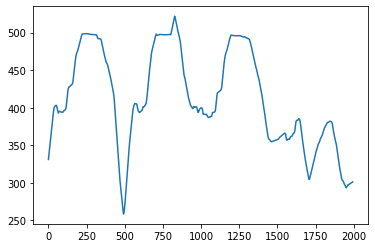

In [99]:
finer_brow_raise_ctrl_points = [[0, 0]]
finer_brow_furrow_ctrl_points = [[0, 0]]


freq = lyric.pitch.selected_array["frequency"]
xs = lyric.xs
freq[freq == 0] = np.nan
mask = np.isnan(freq)
freq[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), freq[~mask])
freq = savgol_filter(freq, 61, 1)
f = interp1d(xs, freq, kind="linear")
for sentence in sentences:
    all_pitch_intervals_slope = []
    all_pitch_intervals_time = []
    si = [lyric.phoneme_intervals[sentence[0]][0],
          lyric.phoneme_intervals[sentence[-1]][1]]
    fs = f(np.arange(si[0], min(si[1], xs[-1]), 0.01))
    max_fs = fs.max()
    min_fs = fs.min()
    mean_fs = (max_fs * 0.7 + min_fs * 0.3)
    # the starting point is always at 
    starting_freq = fs[0]
                
    for phone in sentence:
        if len(lyric.pitch_slopes[phone]) == 0:
            pitch_interval_time = lyric.phoneme_intervals[phone]
            prev_freq = f(min(pitch_interval_time[0], xs[-1]))
            next_freq = f(min(pitch_interval_time[1], xs[-1]))
            raise_ctrl_pts_i, furrow_ctrl_pts_i = get_brow_ctrl_pts(max_fs-mean_fs, 
            mean_fs-min_fs, prev_freq, next_freq, mean_fs, pitch_interval_time)
            finer_brow_raise_ctrl_points.extend(raise_ctrl_pts_i)
            finer_brow_furrow_ctrl_points.extend(furrow_ctrl_pts_i)
            
        else:
            for i in range(0, len(lyric.pitch_slopes[phone])):
                pitch_interval_time = lyric.pitch_intervals[phone][i]
                prev_freq = f(min(pitch_interval_time[0], xs[-1]))
                next_freq = f(min(pitch_interval_time[1], xs[-1]))
                raise_ctrl_pts_i, furrow_ctrl_pts_i = get_brow_ctrl_pts(max_fs-mean_fs, 
                mean_fs-min_fs, prev_freq, next_freq, mean_fs, pitch_interval_time)
                finer_brow_raise_ctrl_points.extend(raise_ctrl_pts_i)
                finer_brow_furrow_ctrl_points.extend(furrow_ctrl_pts_i)
        

In [ ]:
output ={"viseme":[viseme_list, viseme_intervals],
        "brow":[brow_movement, brow_ctrl_points, finer_brow_raise_ctrl_points, finer_brow_furrow_ctrl_points],
        "blink":[eye_movement, eye_ctrl_points],
        "jaw":jaw_ctrl_pts,
        "lip":lip_ctrl_pts, 
        "vib":vib_ctrl_pts}
jsonoutput = json.dumps(output)
with open(os.path.join(dir, file_name_template+'_animation_data.json'), 'w') as outfile:
    json.dump(jsonoutput, outfile)

## 2. Bootleg Jali

In [100]:
from util.CMU2JALI import *
CMU_VOCABULARY = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH', 'ER', 'EY', 'F', 'G',
                  'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH',
                  'UW', 'V', 'W', 'Y', 'Z', 'ZH'])
LIP_HEAVY_VISEMES_JALI = set(["Oh_pointer", "W_pointer", "U_pointer", "SZ_pointer", "JY_pointer"])
NASAL_OBSTRUENTS_JALI = set(["LNTD_pointer", "GK_pointer", "FV_pointer", "MBP_pointer", ])
LABIAL_AND_DENTAL_JALI = set(["MBP_pointer", "SZ_pointer", "FV_pointer"])
SEMIVOWELS_CMU = set(["Y", "W", "H"])


In [101]:
phoneme_list = lyric.phoneme_list
phoneme_interval = lyric.phoneme_intervals

In [102]:
def get_kth_neighbour(input_list, i, k):
    if i+k < 0 or i+k >= len(input_list):
        return None
    return input_list[i+k]

In [103]:
viseme_list = []
viseme_intervals = []
phoneme_list_pure = []
prev_vowel = "Uh"
next_vowel = ""
# pass 1
for i in range(0, len(phoneme_list)):
    if phoneme_list[i] in CMU_VOCABULARY:
        onset = 0.12
        offset = 0.12
        viseme_jali = CMU2VISEME[phoneme_list[i]]+"_pointer"
        if viseme_jali in LIP_HEAVY_VISEMES_JALI:
            onset = 0.16
            offset = 0.16
        start = phoneme_interval[i][0]
        end = phoneme_interval[i][1]
        if (end - start) <= 0.4:
            value = 5
            sustain = 0.75
            decay = 0.75
        else:
            value = 8
            sustain = 0.9
            decay = 0.95
        
        if not viseme_jali in VOWELS_JALI:
            value = 9
        viseme_curve = generate_animation_ctrl_pts(start, end, value, sustain=0.75, decay=decay, onset=onset, offset=offset)
        viseme_list.append(viseme_jali)
        phoneme_list_pure.append(phoneme_list[i])
        viseme_intervals.append(viseme_curve)
# pass 2 enforcing co-articulation
viseme_list_final = []
viseme_intervals_final = []

i = 0;
prev_vowel = 0
prev_consonants = 0

while i < len(viseme_list):
    increment = 1
    i_next = min(i + 1, len(viseme_list)-1)
    if (viseme_list[i_next] == viseme_list[i] and
       viseme_list[i_next] in CONSONANTS_JALI):
        viseme_list_final.append(viseme_list[i_next])
        int_curr = viseme_intervals[i]
        int_next = viseme_intervals[i_next]
        viseme_interval = [int_curr[0], int_curr[1], int_next[0], int_next[1]]
        increment = 2
    elif phoneme_list_pure[i] in SEMIVOWELS_CMU and viseme_list[i_next] in VOWELS_JALI:
        viseme_list_final.append(viseme_list[i_next])
        int_curr = viseme_intervals[i]
        int_next = viseme_intervals[i_next]
        viseme_interval = [int_curr[0], int_curr[1], int_next[0], int_next[1]]
        increment = 2
    elif viseme_list[i] in LIP_HEAVY_VISEMES_JALI:
        current_interval = viseme_intervals[i] 
        if not get_kth_neighbour(viseme_list, i, -1) is None:
            current_interval[0][0] = viseme_intervals[i-1][0][0]
            current_interval[1][0] = viseme_intervals[i-1][1][0]
        if not get_kth_neighbour(viseme_list, i, +1) is None:
            current_interval[2][0] = viseme_intervals[i+1][0][0]
            current_interval[3][0] = viseme_intervals[i+1][1][0]
        viseme_list_final.append(viseme_list[i])
        viseme_intervals_final.append(current_interval)
    elif viseme_list[i] in NASAL_OBSTRUENTS_JALI:
        # these have no effect on Jaw if they are not Sibilants
        temp_interval = viseme_intervals[i]
        length = temp_interval[2][0]-temp_interval[1][0]
        if length > 1/25:
            viseme_list_final.append(viseme_list[i])
            viseme_intervals_final.append(viseme_intervals[i])
        else:    
            temp = viseme_list[i].split("_")
            viseme_list_final.append(temp[0] + "a_" + temp[1])
            viseme_intervals_final.append(viseme_intervals[i])
    else:
        viseme_list_final.append(viseme_list[i])
        viseme_intervals_final.append(viseme_intervals[i])
        
    if viseme_list[i] in CONSONANTS_JALI:
        current_consonant_id = i
    elif viseme_list[i] in VOWELS_JALI:
        current_vowel_id = i
    i = i + increment


### 2.1.a: Jali parameter version 1

In [104]:
# get the jali_parameters
DEFALT_JALI_VAL = 6

jaw_ctrl_pts = []
lip_ctrl_pts = []

# get information on the frequency
freq = lyric.pitch.selected_array["frequency"]
xs = lyric.xs
freq[freq == 0] = np.nan
mask = np.isnan(freq)
freq[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), freq[~mask])
freq = savgol_filter(freq, 21, 3)
f = interp1d(xs, freq, kind="linear")
for sentence in sentences:
    all_pitch_intervals_slope = []
    all_pitch_intervals_time = []
    si = [lyric.phoneme_intervals[sentence[0]][0],
          lyric.phoneme_intervals[sentence[-1]][1]]
    fs = f(np.arange(si[0], min(si[1], xs[-1]), 0.01))
    max_fs = fs.max()
    min_fs = fs.min()
    # the starting point is always at 
    current_freq = fs[0]
    jaw_ctrl_pt_0 = [lyric.phoneme_intervals[sentence[0]][0]-0.02, 6 + (current_freq-min_fs)/(max_fs-min_fs) * 4]
    jaw_ctrl_pts.append(jaw_ctrl_pt_0)
    lip_ctrl_pt_0 = [lyric.phoneme_intervals[sentence[0]][0]-0.02, 6 + (current_freq-min_fs)/(max_fs-min_fs) * 4]
    lip_ctrl_pts.append(lip_ctrl_pt_0)
    prev_voice_type = "chest"
    for phone in sentence:
        if len(lyric.pitch_slopes[phone]) == 0 and len(lyric.voice_quality_lists[phone]) > 0:
            pitch_interval_time = lyric.phoneme_intervals[phone]
            if lyric.voice_quality_lists[phone][0] == "head":
                # the pitch at the beginning of the intervals
                prev_jaw_val = f(pitch_interval_time[0])
                # pitch at the end of the interval (also updates it)
                current_freq = f(pitch_interval_time[1])
                new_jaw_val = DEFALT_JALI_VAL + (current_freq - min_fs)/(max_fs-min_fs) * 4
                jaw_ctrl_pts.append([pitch_interval_time[0], prev_jaw_val])
                jaw_ctrl_pts.append([pitch_interval_time[1], new_jaw_val])
                if prev_voice_type == "belt":
                    lip_ctrl_pts.append([pitch_interval_time[0], DEFALT_JALI_VAL])
                    lip_ctrl_pts.append([pitch_interval_time[1], DEFALT_JALI_VAL])
                prev_voice_type = "head"
            elif lyric.voice_quality_lists[phone][0] == "belt":
                # the pitch at the beginning of the intervals
                prev_lip_val = lip_ctrl_pts[-1][1]
                # pitch at the end of the interval (also updates it)
                current_freq = f(pitch_interval_time[0])
                new_lip_val = DEFALT_JALI_VAL + (current_freq - min_fs)/(max_fs-min_fs) * 4
                lip_ctrl_pts.append([pitch_interval_time[0], prev_lip_val])
                lip_ctrl_pts.append([pitch_interval_time[1], new_lip_val])
                if prev_voice_type == "head":
                    jaw_ctrl_pts.append([pitch_interval_time[0], DEFALT_JALI_VAL])
                    jaw_ctrl_pts.append([pitch_interval_time[1], DEFALT_JALI_VAL])
                prev_voice_type = "belt"
        for i in range(0, len(lyric.pitch_slopes[phone])):
            pitch_interval_time = lyric.pitch_intervals[phone][i]
            if lyric.pitch_slopes[phone][i] > 0 and lyric.voice_quality_lists[phone][i] == "head":
                # the pitch at the beginning of the intervals
                prev_jaw_val = jaw_ctrl_pts[-1][1]
                # pitch at the end of the interval (also updates it)
                current_freq = f(pitch_interval_time[0]) + lyric.pitch_slopes[phone][i] * (pitch_interval_time[1] - pitch_interval_time[0])
                new_jaw_val = DEFALT_JALI_VAL + (current_freq - min_fs)/(max_fs-min_fs) * 4
                jaw_ctrl_pts.append([pitch_interval_time[0], prev_jaw_val])
                jaw_ctrl_pts.append([pitch_interval_time[1], new_jaw_val])
                if prev_voice_type == "belt":
                    lip_ctrl_pts.append([pitch_interval_time[0], DEFALT_JALI_VAL])
                    lip_ctrl_pts.append([pitch_interval_time[1], DEFALT_JALI_VAL])
                prev_voice_type = "head"
            elif lyric.pitch_slopes[phone][i] > 0 and lyric.voice_quality_lists[phone][i] == "belt":
                # the pitch at the beginning of the intervals
                prev_lip_val = lip_ctrl_pts[-1][1]
                # pitch at the end of the interval (also updates it)
                current_freq = f(pitch_interval_time[0]) + lyric.pitch_slopes[phone][i] * (pitch_interval_time[1] - pitch_interval_time[0])
                new_lip_val = DEFALT_JALI_VAL + (current_freq - min_fs)/(max_fs-min_fs) * 4
                lip_ctrl_pts.append([pitch_interval_time[0], prev_lip_val])
                lip_ctrl_pts.append([pitch_interval_time[1], new_lip_val])
                if prev_voice_type == "head":
                    jaw_ctrl_pts.append([pitch_interval_time[0], DEFALT_JALI_VAL])
                    jaw_ctrl_pts.append([pitch_interval_time[1], DEFALT_JALI_VAL])
                prev_voice_type = "belt"
            elif lyric.pitch_slopes[phone][i] > 0 and lyric.voice_quality_lists[phone][i] == "chest":
                # the pitch at the beginning of the intervals
                prev_jaw_val = jaw_ctrl_pts[-1][1]
                # pitch at the end of the interval (also updates it)
                current_freq = f(pitch_interval_time[0]) + lyric.pitch_slopes[phone][i] * (pitch_interval_time[1] - pitch_interval_time[0])
                new_jaw_val = DEFALT_JALI_VAL + (current_freq - min_fs)/(max_fs-min_fs) * 4
                jaw_ctrl_pts.append([pitch_interval_time[0], prev_jaw_val])
                jaw_ctrl_pts.append([pitch_interval_time[1], new_jaw_val])
                if prev_voice_type == "belt":
                    lip_ctrl_pts.append([pitch_interval_time[0], DEFALT_JALI_VAL])
                    lip_ctrl_pts.append([pitch_interval_time[1], DEFALT_JALI_VAL])
#                 if prev_voice_type == "head":
#                     jaw_ctrl_pts.append([pitch_interval_time[0], DEFALT_JALI_VAL])
#                     jaw_ctrl_pts.append([pitch_interval_time[1], DEFALT_JALI_VAL])
                prev_voice_type = "chest"
            elif lyric.pitch_slopes[phone][i] < 0: # these are opportunities to bring 
                # the pitch at the beginning of the intervals
                prev_jaw_val = jaw_ctrl_pts[-1][1]
                prev_lip_val = lip_ctrl_pts[-1][1]
                # pitch at the end of the interval (also updates it)
                current_freq = f(pitch_interval_time[0]) + lyric.pitch_slopes[phone][i] * (pitch_interval_time[1] - pitch_interval_time[0])
                new_jaw_val = DEFALT_JALI_VAL + (current_freq - min_fs)/(max_fs-min_fs) * 4
                new_lip_val = DEFALT_JALI_VAL + (current_freq - min_fs)/(max_fs-min_fs) * 4
                jaw_ctrl_pts.append([pitch_interval_time[0], prev_jaw_val])
                jaw_ctrl_pts.append([pitch_interval_time[1], max(new_jaw_val, DEFALT_JALI_VAL)])
                lip_ctrl_pts.append([pitch_interval_time[0], prev_lip_val])
                lip_ctrl_pts.append([pitch_interval_time[1], max(new_lip_val, DEFALT_JALI_VAL)])
                prev_voice_type = lyric.voice_quality_intervals[phone][i]
            elif ((prev_voice_type == "head" and lyric.voice_quality_intervals[phone][i] == "belt") or 
                  (prev_voice_type == "belt" and lyric.voice_quality_intervals[phone][i] == "head")):
                prev_jaw_val = jaw_ctrl_pts[-1][1]
                prev_lip_val = lip_ctrl_pts[-1][1]
                jaw_ctrl_pts.append([pitch_interval_time[0], prev_lip_val])
                jaw_ctrl_pts.append([pitch_interval_time[1], prev_lip_val])
                lip_ctrl_pts.append([pitch_interval_time[0], prev_jaw_val])
                lip_ctrl_pts.append([pitch_interval_time[1], prev_jaw_val])
                prev_voice_type = lyric.voice_quality_intervals[phone][i]
                
                
                

In [111]:
vib_ctrl_pts = []
for k in lyric.vibrato_intervals:
    if len(k) > 0:
        for m in k:
            vib_ctrl_pts.append(m)

In [109]:
output ={"viseme":[viseme_list, viseme_intervals],
        "brow":[brow_movement, brow_ctrl_points, finer_brow_raise_ctrl_points, finer_brow_furrow_ctrl_points],
        "blink":[eye_movement, eye_ctrl_points],
        "jaw":jaw_ctrl_pts,
        "lip":lip_ctrl_pts, 
        "vib":vib_ctrl_pts}
jsonoutput = json.dumps(output)
with open(os.path.join(dir, file_name_template+'_animation_data.json'), 'w') as outfile:
    json.dump(jsonoutput, outfile)

## 3. Simple head movements

In [ ]:
def get_a_shake(t_start, t_end, prev_motion_x, prev_motions_y):
    

In [ ]:
# break the thing into sentence structures
sentences = []
current_sentence = []
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] == "EOS_tag":
        sentences.append(current_sentence)
        current_sentence = []
    else:
        current_sentence.append(i)
        if i == len(lyric.phoneme_list) - 1:
            sentences.append(current_sentence)
sentences = sentences[1:] 

x_dir_head = []
y_dir_head = []

for sentence in sentences:
    

# Studying eye brow movements using facial landmarking

In [57]:
from util.facial_landmarking import *

In [58]:
video_title = ["video.mp4"]
video_path = ["E:/facial_data_analysis_videos/1"]
extract_landmarks_media_pipe(video_title[0],
                         video_path[0], save_annotated_video=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:/facial_data_analysis_videos/1'